# Classification

Like last week, this problem set is more a demo than a real task for you to perform. All you need to do is read and execute the code below. Note the import statements in the first code block, which load the libraries responsible for the heavy lifting.

When you've run all the code blocks below, upload your copy of the notebook to Sakai as your submission. Again, the idea is just for you to have this in your back pocket for intellectual reference and to use as the basis for other corpus work.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

from nltk.corpus.reader.plaintext import CategorizedPlaintextCorpusReader
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

# Location of the corpus texts
txt_dir = os.path.join('..', '..', 'data', 'texts') # <- MODIFY THIS LOCATION TO SUIT

## Literature data

OK, so what we want to do is to build a classifier that can tell the difference between American- and British-authored novels in our 40-volume literary corpus.

In [2]:
# Set up an NLTK corpus reader
corpus = CategorizedPlaintextCorpusReader(
    txt_dir,              # corpus location
    r'.*\.txt',           # corpus files end in '.txt'
    cat_pattern=r'(\w).*' # corpus categories indicated by first letter of each file name
)

# Retrieve document categories
labels = [corpus.categories(fileids=[i])[0] for i in corpus.fileids()]

# Vectorizer to texts into TFIDF-weighted features
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_df=0.7,
    min_df=2,
    binary=True,
    use_idf=True,
    norm='l2'
)

# Set up dimension-reducer for plotting
reducer = TruncatedSVD(
    n_components=1000 # Turn 20,000+ text dimensions into fewer for classification 
)

# A function to iterate over the documents in our corpus
def get_documents(corpus):
    """Get the corpuments from a corpus"""
    for fileid in corpus.fileids():
        yield corpus.raw(fileids=[fileid])
        
# Vectorize
features = vectorizer.fit_transform(get_documents(corpus)) # Documents -> features

# Reduce dimension
features = reducer.fit_transform(features)

# Classify and cross-validate
scores = cross_validate(LogisticRegression(solver='lbfgs'), features, labels, cv=5)
print("Average logistic regression classifier score:", np.mean(scores['test_score']))

Average logistic regression classifier score: 0.775


In [3]:
%%time
# Now evaluate a bunch of classifiers
classifiers = [
    AdaBoostClassifier(),
    BernoulliNB(),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    KNeighborsClassifier(),
    LinearSVC(),
    LogisticRegression(solver='liblinear'),
    MLPClassifier(alpha=1.0), # Slow!
    NearestCentroid(),
    PassiveAggressiveClassifier(max_iter=1000, tol=1e-3),
    Perceptron(max_iter=1000, tol=1e-3),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    RidgeClassifier(tol=1e-2, solver="lsqr"),
    SGDClassifier(max_iter=1000, tol=1e-3),
    SVC(gamma=2, C=1)
]

iterations = 10 # Cross validation runs per classifier

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    results = {}
    for classifier in classifiers:
        clf_scores = {}
        clf_name = classifier.__class__.__name__
        print(clf_name)
        for i in range(iterations):
            scores = cross_validate(classifier, features, labels, cv=10, return_train_score=False)
            for key in scores.keys():
                if key in clf_scores.keys():
                    for value in scores[key]:
                        clf_scores[key].append(value)
                else:
                    clf_scores[key] = list(scores[key])
        results[clf_name] = clf_scores

AdaBoostClassifier
BernoulliNB
DecisionTreeClassifier
GaussianNB
GaussianProcessClassifier
KNeighborsClassifier
LinearSVC
LogisticRegression
MLPClassifier
NearestCentroid
PassiveAggressiveClassifier
Perceptron
QuadraticDiscriminantAnalysis
RandomForestClassifier
RidgeClassifier
SGDClassifier
SVC
CPU times: user 29.1 s, sys: 62.6 ms, total: 29.1 s
Wall time: 17.7 s


,score,std,time
Perceptron,0.8250,0.160078,0.000438
LogisticRegression,0.8000,0.187083,0.000365
PassiveAggressiveClassifier,0.7900,0.182757,0.000440
MLPClassifier,0.7775,0.183354,0.082678
RidgeClassifier,0.7750,0.175000,0.000963
NearestCentroid,0.7750,0.175000,0.000249
LinearSVC,0.7750,0.175000,0.000428
AdaBoostClassifier,0.7500,0.250000,0.042357
GaussianNB,0.7500,0.158114,0.000550
SVC,0.7500,0.193649,0.000402


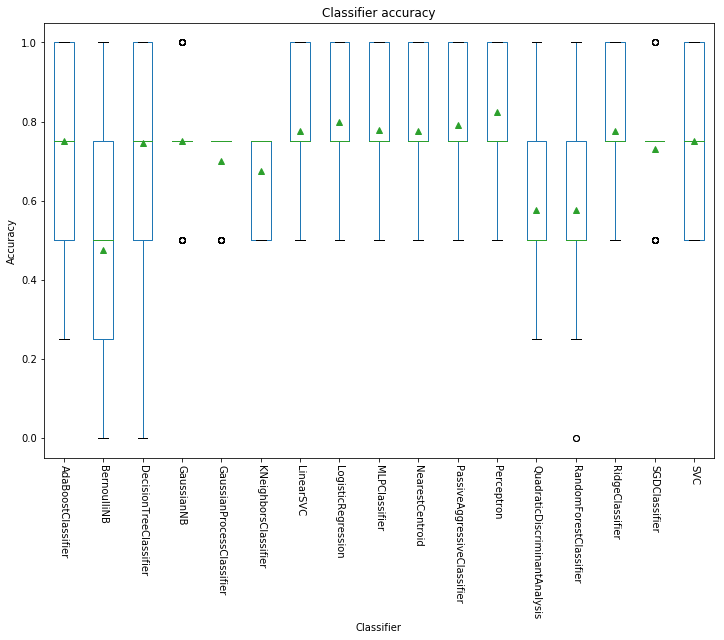

In [4]:
# Tabulate and plot results
df = pd.DataFrame.from_dict(results, orient='index')
df['time'] = df.fit_time.apply(lambda x: np.mean(np.asarray(x)))
df['score'] = df.test_score.apply(lambda x: np.mean(np.asarray(x)))
df['std'] = df.test_score.apply(lambda x: np.std(np.asarray(x)))
display(df[['score', 'std', 'time']].sort_values(by='score', ascending=False))

# Plot results
pd.DataFrame(
    df['test_score'].values.tolist(), 
    index=df.index
).T.plot.box(
    figsize=(12,8), 
    rot=-90, 
    sort_columns=True,
    showmeans=True
)
plt.title("Classifier accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Classifier")
plt.show()